In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
plt.rcParams['figure.figsize'] = [15, 10]

# Задание 1. Работа с реальными данными

Напишите функции read_gff и read_bed6 для чтения соответствующих форматов. Они должны возвращать датафреймы как в примере (картинка Example1), но имена колонок можно сделать любыми.

In [4]:
def read_gff(file):
    gff = pd.read_table(file, sep='\t', skiprows=1, names=['chromosome', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
    return gff

gff = read_gff('~/IB/python/Python_BI_2022/homework_5_pandas/rrna_annotation.gff')
gff.head()

,chromosome,source,type,start,end,score,strand,phase,attributes
0,Reference_10,barrnap:0.9,rRNA,67122,68652,0.0,+,.,Name=16S_rRNA;product=16S ribosomal RNA
1,Reference_10,barrnap:0.9,rRNA,68981,72061,0.0,+,.,Name=23S_rRNA;product=23S ribosomal RNA
2,Reference_10,barrnap:0.9,rRNA,469298,470826,0.0,+,.,Name=16S_rRNA;product=16S ribosomal RNA
3,Reference_10,barrnap:0.9,rRNA,471166,474246,0.0,+,.,Name=23S_rRNA;product=23S ribosomal RNA
4,Reference_10,barrnap:0.9,rRNA,3629599,3632680,0.0,-,.,Name=23S_rRNA;product=23S ribosomal RNA


In [5]:
def read_bed6(file):
    bed = pd.read_table(file, sep='\t', names=['chromosome', 'start', 'end', 'name', 'score', 'strand'])
    return bed

bed = read_bed6('~/IB/python/Python_BI_2022/homework_5_pandas/alignment.bed')
bed.head()

,chromosome,start,end,name,score,strand
0,Reference_1,197681,200286,NODE_1445_length_2603_cov_1135.593799,41,-
1,Reference_1,202886,202996,NODE_19543_length_110_cov_1549.290909,0,-
2,Reference_1,202941,203377,NODE_5666_length_436_cov_418.653543,16,+
3,Reference_1,203322,785222,NODE_25_length_581906_cov_146.024228,60,+
4,Reference_1,785169,1763981,NODE_11_length_978812_cov_132.517515,60,-


Колонка с атрибутами несёт слишком много избыточной информации и ей не удобно пользоваться, оставьте в ней только данные о типе рРНК одной короткой строкой (16S, 23S, 5S).

In [6]:
gff['attributes'] = gff['attributes'].str.extract(r'(\d+S)')

In [7]:
gff.head()

,chromosome,source,type,start,end,score,strand,phase,attributes
0,Reference_10,barrnap:0.9,rRNA,67122,68652,0.0,+,.,16S
1,Reference_10,barrnap:0.9,rRNA,68981,72061,0.0,+,.,23S
2,Reference_10,barrnap:0.9,rRNA,469298,470826,0.0,+,.,16S
3,Reference_10,barrnap:0.9,rRNA,471166,474246,0.0,+,.,23S
4,Reference_10,barrnap:0.9,rRNA,3629599,3632680,0.0,-,.,23S


In [8]:
gff['attributes'].unique()

array(['16S', '23S', '5S'], dtype=object)

Сделайте таблицу, где для каждой хромосомы (на самом деле это не хромосомы, а референсные геномы) показано количество рРНК каждого типа. Постройте barplot, отображающий эти данные (картинка rRNA_barplot)

In [9]:
rrna_types = gff[['chromosome', 'attributes']].value_counts().to_frame().reset_index('chromosome').reset_index('attributes')
rrna_types = rrna_types.rename(columns={0: 'count'})

rrna_types['sort_att'] = rrna_types['attributes'].str.extract('(\d+)').astype(int)
rrna_types['sort_ch'] = rrna_types['chromosome'].str.extract('(\d+)').astype(int)
rrna_types = rrna_types.sort_values(by=['sort_ch', 'sort_att'], ignore_index=True)
rrna_types = rrna_types.drop(['sort_att', 'sort_ch'], axis=1)

rrna_types.head()

,attributes,chromosome,count
0,5S,Reference_1,2
1,16S,Reference_1,2
2,23S,Reference_1,2
3,5S,Reference_2,5
4,16S,Reference_2,5


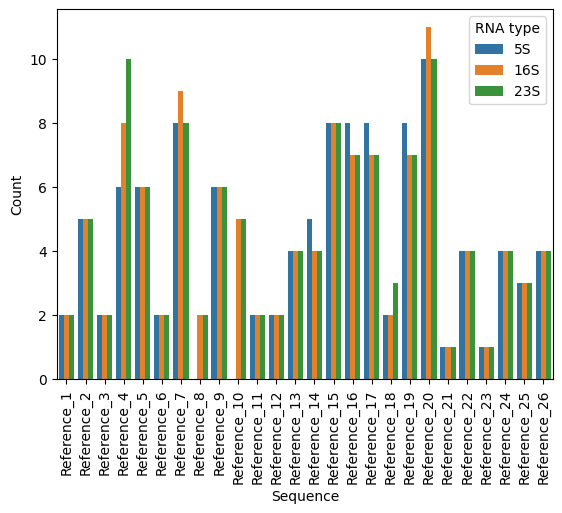

In [10]:
fig1 = sns.barplot(rrna_types, x = 'chromosome', y = 'count', hue='attributes')
fig1.set(xlabel='Sequence', ylabel='Count')
fig1.legend(title='RNA type')
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90)
plt.show()

Далее самое интересное. Мы хотим узнать сколько рРНК в процессе сборки успешно собралось. Для этого можно воспользоваться программой bedtools intersect и пересечь эти два файла. В результате сохранятся только записи об рРНК, интервал которой перекрывался с интервалом контига в выравнивании, это означает, что это ген есть в сборке. Но забудьте про bedtools! У нас тут вообще-то пандас! Поэтому давайте получим такой же результат в нём. Выведите таблицу, содержащую исходные записи об рРНК полностью вошедших в сборку (не фрагментом), а также запись о контиге в который эта РНК попала. Итоговая таблица должна выглядеть примерно так (картинка Example2). Обратите внимание, что в один контиг может попасть несколько рРНК.

In [12]:
intersected = bed.merge(gff, on='chromosome', suffixes=['_x', '_y'])
intersected

,chromosome,start_x,end_x,name,score_x,strand_x,source,type,start_y,end_y,score_y,strand_y,phase,attributes
0,Reference_1,197681,200286,NODE_1445_length_2603_cov_1135.593799,41,-,barrnap:0.9,rRNA,198291,199763,0.000000e+00,+,.,16S
1,Reference_1,197681,200286,NODE_1445_length_2603_cov_1135.593799,41,-,barrnap:0.9,rRNA,200189,203097,0.000000e+00,+,.,23S
2,Reference_1,197681,200286,NODE_1445_length_2603_cov_1135.593799,41,-,barrnap:0.9,rRNA,203221,203321,1.800000e-11,+,.,5S
3,Reference_1,197681,200286,NODE_1445_length_2603_cov_1135.593799,41,-,barrnap:0.9,rRNA,1763983,1764083,1.800000e-11,-,.,5S
4,Reference_1,197681,200286,NODE_1445_length_2603_cov_1135.593799,41,-,barrnap:0.9,rRNA,1764208,1767116,0.000000e+00,-,.,23S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126743,Reference_26,5537288,5608040,NODE_237_length_95089_cov_34.836785,60,+,barrnap:0.9,rRNA,4751643,4754533,0.000000e+00,-,.,23S
126744,Reference_26,5537288,5608040,NODE_237_length_95089_cov_34.836785,60,+,barrnap:0.9,rRNA,4754656,4756174,0.000000e+00,-,.,16S
126745,Reference_26,5537288,5608040,NODE_237_length_95089_cov_34.836785,60,+,barrnap:0.9,rRNA,5532457,5532551,2.100000e-09,-,.,5S
126746,Reference_26,5537288,5608040,NODE_237_length_95089_cov_34.836785,60,+,barrnap:0.9,rRNA,5532663,5535553,0.000000e+00,-,.,23S


_Проставляем минусы, чтобы сравнять позиции аннотаций GFF и BED: -1 для start_y и end_y от GFF, и дополнительный -1 для end от GFF, так как GFF end включает конец интервала, а BED end - нет_

In [16]:
intersected = intersected[intersected['start_x'] <= (intersected['start_y'] - 1)][intersected['end_x'] >= intersected['end_y'] - 2]

/var/folders/lr/tz5w155s1wv9t8nfchl8bm700000gn/T/ipykernel_73441/1830726988.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  intersected = intersected[intersected['start_x'] <= (intersected['start_y'] - 1)][intersected['end_x'] >= intersected['end_y'] - 2]


In [17]:
intersected

,chromosome,start_x,end_x,name,score_x,strand_x,source,type,start_y,end_y,score_y,strand_y,phase,attributes
0,Reference_1,197681,200286,NODE_1445_length_2603_cov_1135.593799,41,-,barrnap:0.9,rRNA,198291,199763,0.000000e+00,+,.,16S
14,Reference_1,202941,203377,NODE_5666_length_436_cov_418.653543,16,+,barrnap:0.9,rRNA,203221,203321,1.800000e-11,+,.,5S
33,Reference_1,1763926,1764363,NODE_5666_length_436_cov_418.653543,0,-,barrnap:0.9,rRNA,1763983,1764083,1.800000e-11,-,.,5S
47,Reference_1,1767018,1769623,NODE_1445_length_2603_cov_1135.593799,0,+,barrnap:0.9,rRNA,1767542,1769014,0.000000e+00,-,.,16S
1651,Reference_2,338265,339012,NODE_3705_length_710_cov_6689.190840,16,-,barrnap:0.9,rRNA,338894,339005,7.700000e-11,+,.,5S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125747,Reference_26,4751412,4754581,NODE_1329_length_3169_cov_103.935132,0,+,barrnap:0.9,rRNA,4751643,4754533,0.000000e+00,-,.,23S
125772,Reference_26,4754647,4756206,NODE_2001_length_1559_cov_98.029920,0,+,barrnap:0.9,rRNA,4754656,4756174,0.000000e+00,-,.,16S
126697,Reference_26,5532432,5535601,NODE_1329_length_3169_cov_103.935132,5,+,barrnap:0.9,rRNA,5532457,5532551,2.100000e-09,-,.,5S
126698,Reference_26,5532432,5535601,NODE_1329_length_3169_cov_103.935132,5,+,barrnap:0.9,rRNA,5532663,5535553,0.000000e+00,-,.,23S


# Задание 2. Кастомизация графиков

Для визуализации данных дифференциальной экспрессии генов, можно использовать специальный тип графика - volcano plot. По оси X на нём отложен logFC (Logarithmic Fold Change) - во сколько раз изменилась экспрессия гена в степенях двойки (logFC=-8 - экспрессия гена изменилась в 2^-8 раз). По оси Y откладывается уровень значимости данных изменений в виде отрицательного десятичного логарифма p-value (с поправкой на множественное сравнение).

В данном задании вам нужно максимально точно воспроизвести график volcano_plot.png (прикреплён к заданию). Для этого используйте файл с данными diffexpr_data.tsv.gz (пандас умеет открывать .gz файлы, поэтому разжимать их не обязательно). Данные уже предобработаны, считать p-value и брать логарифмы уже не надо, просто используйте колонки logFC и log_pval. Если необходимо, можете делать группировку данных или брать subsets, но в итоге на графике должны быть именно значения из этих колонок. Ниже приведён чеклист кастомизаций для удобства, чем больше вы сделаете, тем лучше.
1. Четыре сегмента на графике
    a. Цвета сегментов
    b. Разделение сегментов пунктирными линиями
        i. Серый цвет линий
        ii. Пунктирность линий
        iii. Толщина линий
    с. Подпись "p_value = 0.05" над соответствующей линией
    d. Размер точек
2. Оси и лейблы
    a. xlabel, ylabel и title - жирным курсивом, размером +- как на картинке
    b. Основание логарифма в нижнем регистре
    с. Размер и толщина ticks на осях X и Y (minor ticks должны отображаться)
    d. Симметричные лимиты для оси X, но чтобы все данные помещались. Условно, если минимальный logFC = -1, а максимальный logFC = 10, то значения по оси X должны отображаться от -11 до 11 (+-1 нужно для того, чтобы на график поместилась крайняя точка). Вычислите эти лимиты из данных, а не вбивайте готовые числа
    e. Толщина осей
3. Легенда
    a. Размер и шрифт букв в легенде
    b. Размер маркеров в легенде
    с. Небольшая тень от легенды вправо вниз
4. Проаннотировать топ-2 генов, значимо снизивших экспрессию, и топ-2 генов, значимо увеличивших экспрессию
    a. Стрелочки
        i. Красные с чёрной гранью
        ii. Направление стрелок - произвольное
    b. Текст у стрелочек
        i. Жирный


Если выполнить все требования из чеклиста и поиграться с размером Figure и dpi, то должно получиться примерно как в образце.

In [42]:
diff = pd.read_csv('~/IB/python/Python_BI_2022/homework_5_pandas/diffexpr_data.tsv.gz', sep='\t')

In [20]:
diff

,Sample,logFC,pval,pval_corr,log_pval
0,PNLIP,10.092524,6.590327e-01,1.000000e+00,-0.000000
1,CELA2A,8.691414,5.823905e-01,1.000000e+00,-0.000000
2,CLPS,8.054078,6.517331e-01,1.000000e+00,-0.000000
3,MPO,7.817773,4.483336e-01,1.000000e+00,-0.000000
4,AMY2A,7.285231,6.324412e-01,1.000000e+00,-0.000000
...,...,...,...,...,...
20525,SLC12A1,-7.834589,4.993254e-58,1.025115e-53,52.989227
20526,SEMG2,-8.651953,3.989840e-04,1.000000e+00,-0.000000
20527,MUC7,-9.196481,3.281804e-07,6.737544e-03,2.171498
20528,SEMG1,-9.313028,3.880575e-04,1.000000e+00,-0.000000


In [43]:
diff.loc[(diff['logFC'] >= 0) & (diff['pval_corr'] >= 0.05), 'segments'] = 'ns_up'
diff.loc[(diff['logFC'] < 0) & (diff['pval_corr'] >= 0.05), 'segments'] = 'ns_down'
diff.loc[(diff['logFC'] >= 0) & (diff['pval_corr'] < 0.05), 'segments'] = 's_up'
diff.loc[(diff['logFC'] < 0) & (diff['pval_corr'] < 0.05), 'segments'] = 's_down'

In [47]:
sorter = ['s_down', 's_up', 'ns_down', 'ns_up']
diff['segments'] = diff['segments'].astype('category')
diff['segments'] = diff['segments'].cat.set_categories(sorter)
#diff = diff.sort_values(by=['segments'], ignore_index=True)

In [45]:
diff

,Sample,logFC,pval,pval_corr,log_pval,segments
0,PNLIP,10.092524,6.590327e-01,1.000000e+00,-0.000000,ns_up
1,CELA2A,8.691414,5.823905e-01,1.000000e+00,-0.000000,ns_up
2,CLPS,8.054078,6.517331e-01,1.000000e+00,-0.000000,ns_up
3,MPO,7.817773,4.483336e-01,1.000000e+00,-0.000000,ns_up
4,AMY2A,7.285231,6.324412e-01,1.000000e+00,-0.000000,ns_up
...,...,...,...,...,...,...
20525,SLC12A1,-7.834589,4.993254e-58,1.025115e-53,52.989227,s_down
20526,SEMG2,-8.651953,3.989840e-04,1.000000e+00,-0.000000,ns_down
20527,MUC7,-9.196481,3.281804e-07,6.737544e-03,2.171498,s_down
20528,SEMG1,-9.313028,3.880575e-04,1.000000e+00,-0.000000,ns_down


<AxesSubplot: xlabel='logFC', ylabel='log_pval'>

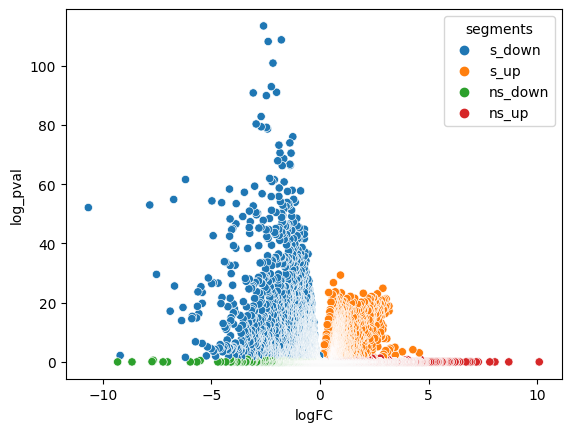

In [48]:
vol = sns.scatterplot(diff, x='logFC', y='log_pval', hue = 'segments')
vol